In [244]:
import pandas as pd
import numpy as np
import pylab as plt
import matplotlib.pyplot as plt
##import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from scipy.stats import skew
import numpy as np
import seaborn as sns
from scipy import stats
color = sns.color_palette()
from sklearn import model_selection, preprocessing
import datetime
import scipy as sp
# Get ready for lots of annoying deprecation warnings
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
#from sklearn_pandas import DataFrameMapper
%matplotlib inline

In [245]:
def clean_data_macro(df):
    # convert object column to numeric
    char_columns = (df.dtypes[df.dtypes.map(lambda x : x =='object')]).index
    float_columns = (df.dtypes[df.dtypes.map(lambda x : x =='float64')]).index
    le=LabelEncoder()
    for feature in char_columns:
        df[feature]=le.fit_transform(df[feature])
    # cvert float64 to float32
    df[float_columns]=df[float_columns].astype(np.float32)
    df.fillna(df.median(),inplace = True)
    return df

### Summary Clean for train set

In [246]:
# drop missing value >0.35 of total observations
# keep state and build_year for training data
def drop_high_volumn_missing(df):
    not_move = ["build_year","state"]
    high_missing_train_feature= df.columns[df.isnull().sum()>0.35*len(df)].tolist()
    
    for g in not_move:
        if g in high_missing_train_feature:
            high_missing_train_feature.remove(g)
    df.drop(high_missing_train_feature,axis = 1, inplace=True)    
    return df

## drop build_ columns: drop na obs or drop columns
def drop_build_function(df):
    not_move = ["build_year"]
    build_feature = df.filter(regex=r'^build_count_', axis=1).columns.tolist()
    build_feature2 = df.filter(regex=r'^raion_build_count_', axis=1).columns.tolist()
    for e in build_feature:
        for g in not_move:
            if e==g:
                high_missing_train_feature.remove(e)
    build_feature.extend(build_feature2)
    df.drop(build_feature,axis = 1)
    return df

# remove outliers
'''def reject_outliers(df, m = 1):
    d = np.abs(df - np.median(df))
    mdev = np.median(d)
    s = d/mdev if mdev else 0.
    return df[s<m]
'''
def reject_outliers(df, iq_range=0.5):
    #df[np.abs(df.Data-df.Data.mean())<=(3*df.Data.std())]
    pcnt = (1 - iq_range) / 2
    qlow, median, qhigh = df.dropna().quantile([pcnt, 0.50, 1-pcnt])
    iqr = qhigh - qlow
    return df[ (df - median).abs() <= iqr]

def clean_data(df):
    #add str feature 
    #df_all.apartment_name=df_all.sub_area + df_all['metro_km_avto'].astype(str)

    # convert object column to numeric
    char_columns = (df.dtypes[df.dtypes.map(lambda x : x =='object')]).index
    float_columns = (df.dtypes[df.dtypes.map(lambda x : x =='float64')]).index
    le=LabelEncoder()
    for feature in char_columns:
        df[feature]=le.fit_transform(df[feature])
    # cvert float64 to float32
    df[float_columns]=df[float_columns].astype(np.float32)
    return df
def handle_missing(df):
    # fill build_ and cafe_, state, NA to 0

    df.filter(regex=r'^cafe_', axis=1).fillna(0, inplace=True)
    #build_feature
    not_move = ["build_year"]
    build_feature = df.filter(regex=r'^build_count_', axis=1).columns.tolist()
    build_feature2 = df.filter(regex=r'^raion_build_count_', axis=1).columns.tolist()
    for e in build_feature:
        for g in not_move:
            if e==g:
                high_missing_train_feature.remove(e)
    build_feature.extend(build_feature2)
    #build fill median or 0?
    df[build_feature].fillna(df[build_feature].median(),inplace=True)
    #fill state
    df['state'].fillna(0,inplace=True) 
    

    return df

In [247]:
# add month year week and other feature
def add_feature(df_all):
    month_year = (df_all.timestamp.dt.month + df_all.timestamp.dt.year * 100)
    month_year_cnt_map = month_year.value_counts().to_dict()
    df_all['month_year_cnt'] = month_year.map(month_year_cnt_map)

    week_year = (df_all.timestamp.dt.weekofyear + df_all.timestamp.dt.year * 100)
    week_year_cnt_map = week_year.value_counts().to_dict()
    df_all['week_year_cnt'] = week_year.map(week_year_cnt_map)

    df_all['month'] = df_all.timestamp.dt.month
    df_all['dow'] = df_all.timestamp.dt.dayofweek

    # Other feature engineering
    df_all['rel_floor'] = df_all['floor'] / df_all['max_floor'].astype(float)
    df_all['rel_kitch_sq'] = df_all['kitch_sq'] / df_all['full_sq'].astype(float)
    
    df_all['rel_kitch_sq'].fillna(0,inplace=True)
    df_all['rel_floor'].fillna(0,inplace=True)
    
    df_all['room_size'] = df_all['life_sq'] / df_all['num_room'].astype(float)
    # df_all.replace(np.inf, np.nan)
    ##trainBuild = df_train.dropna()
     #3* Polynomials on the top 1 existing features
    df_all["full_sq-s2"] = df_all["full_sq"] ** 2
    df_all["full_sq-s3"] = df_all["full_sq"] ** 3
    df_all["full_sq-Sq"] = np.sqrt(df_all["full_sq"])
    df_all["yearbuilt"] = pd.to_numeric(df_all["build_year"].map(lambda x:str(x).split(".")[0]),errors='coerce')
    # Remove timestamp buildyear column (may overfit the model in train)
    #df_all.drop(['timestamp',"id"], axis=1, inplace=True)
    df_all.apartment_name=df_all.sub_area + df_all['metro_km_avto'].astype(str)
    return df_all

In [248]:
#load files
train = pd.read_csv('./data/output/train_clean.csv', parse_dates=['timestamp'])
test = pd.read_csv('./data/output/test_clean.csv', parse_dates=['timestamp'])
macro_cols = ["balance_trade", "balance_trade_growth", "eurrub", "average_provision_of_build_contract",
"micex_rgbi_tr", "micex_cbi_tr", "deposits_rate", "mortgage_value", "mortgage_rate",
"income_per_cap", "rent_price_4+room_bus", "museum_visitis_per_100_cap", "apartment_build"]
macro = pd.read_csv('./data/input/macro.csv',parse_dates=['timestamp']
                    ,usecols=['timestamp']+macro_cols)
#macros = clean_data_macro(macro) #clean macros
num_train = len(train)
#id_test = test.id

In [249]:
#impute macro variable
month_year = (macro.timestamp.dt.month + macro.timestamp.dt.year * 100)
month_year_cnt_map = month_year.value_counts().to_dict()
macro['month_year_cnt'] = month_year.map(month_year_cnt_map)
macro['month_year_cnt'].head()

0    31
1    31
2    31
3    31
4    31
Name: month_year_cnt, dtype: int64

In [250]:
# by monthyear count to compute median 
macro.fillna(macro.groupby("month_year_cnt").median(),inplace =True )

In [251]:
# drop month_year_cnt
macro.drop(["month_year_cnt"], axis=1, inplace=True)

In [252]:
macro.shape

(2484, 14)

In [253]:
all = pd.concat(objs=[train,test],axis = 0)
all.shape

(38058, 292)

In [254]:
df_train = pd.merge_ordered(train, macro, on='timestamp', how='left')
df_train.shape

(30396, 305)

In [255]:
df_all = pd.merge_ordered(all, macro, on='timestamp', how='left')
df_all.shape

(38058, 305)

In [103]:
# Find most important features relative to target
print("Find most important features relative to target")
corr = df_train.corr()
corr.sort_values(["price_doc"], ascending = False, inplace = True)
print(corr.price_doc)

Find most important features relative to target
price_doc                     1.000000
full_sq                       0.616516
num_room                      0.490692
life_sq                       0.484116
kitch_sq                      0.354887
sport_count_5000              0.297394
sport_count_3000              0.292979
trc_count_5000                0.291207
sport_count_2000              0.280532
office_sqm_5000               0.272362
trc_sqm_5000                  0.269786
sport_count_1500              0.260777
sport_objects_raion           0.255460
trc_count_3000                0.244037
cafe_count_5000_price_1000    0.242608
cafe_count_5000_price_1500    0.234759
cafe_count_5000               0.233667
cafe_count_5000_na_price      0.232171
office_sqm_3000               0.229115
cafe_count_5000_price_500     0.229006
cafe_count_5000_price_2500    0.227656
trc_sqm_3000                  0.227451
office_count_5000             0.221321
office_sqm_2000               0.218604
cafe_count_5000_

In [256]:
dall=add_feature(df_all)
print dall.shape

(38058, 316)


In [257]:
dall_missing = handle_missing(dall)
print dall_missing.shape

(38058, 316)


### Select feature

In [258]:
#train low correlated feature or VIF 
#train_feature = pd.read_csv("./data/output/train_feature_multicoliear.csv")
train_feature = pd.read_csv("./data/output/train_corr_drop.csv")# to drop
train_feature.shape

(30471, 142)

In [259]:
#readin train set
#df_train = pd.read_csv("./data/input/train.csv",parse_dates=['timestamp'],
                      #usecols =['timestamp','price_doc','build_year']+train_feature.columns.tolist())
#df_train = pd.read_csv("./data/input/train.csv",parse_dates=['timestamp'])
feature_drop = train_feature.columns.tolist()
y_train =np.log1p(train["price_doc"])
xall=dall_missing.drop(feature_drop, axis = 1)
print xall.shape
xall.head()

(38058, 174)


,0_13_all,0_13_male,ID_big_road1,ID_railroad_station_avto,ID_railroad_station_walk,ID_railroad_terminal,additional_education_km,additional_education_raion,area_m,big_church_count_1000,...,week_year_cnt,month,dow,rel_floor,rel_kitch_sq,room_size,full_sq-s2,full_sq-s3,full_sq-Sq,yearbuilt
0,18654,9709,1,1,1.0,101,0.947962,3,6.407578e+06,1,...,1,8,5,0.0,0.0,NaN,1849.0,79507.0,6.557439,NaN
1,13729,6929,2,2,2.0,32,1.072315,1,9.589337e+06,1,...,2,8,1,0.0,0.0,NaN,1156.0,39304.0,5.830952,NaN
2,11252,5916,3,3,3.0,5,0.391957,1,4.808270e+06,0,...,2,8,5,0.0,0.0,NaN,1849.0,79507.0,6.557439,NaN
3,24934,12782,1,4,4.0,83,0.892674,6,1.258354e+07,0,...,1,9,3,0.0,0.0,NaN,7921.0,704969.0,9.433981,NaN
4,11631,6223,4,113,5.0,113,0.810801,2,8.398461e+06,7,...,5,9,0,0.0,0.0,NaN,5929.0,456533.0,8.774964,NaN


In [260]:
dtype_df = xall.dtypes.reset_index()
dtype_df.columns = ["Count", "Column Type"]
dtype_df.groupby("Column Type").aggregate('count').reset_index()

,Column Type,Count
0,int64,66
1,float64,97
2,datetime64[ns],1
3,object,10


In [261]:
categorical_features = xall.select_dtypes(include = ["object"]).columns
numerical_features = xall.select_dtypes(exclude = ["object"]).columns
numerical_features = numerical_features.drop(["price_doc", 'id',"timestamp"])
print("Numerical features : " + str(len(numerical_features)))
print("Categorical features : " + str(len(categorical_features)))
all_num = xall[numerical_features]
all_cat =xall[categorical_features]

Numerical features : 161
Categorical features : 10


In [262]:
# Handle remaining missing values for numerical features by using median as replacement
print("NAs for numerical features in train and test : " + str(all_num.isnull().values.sum()))
all_num = all_num.fillna(all_num.median())
print("Remaining NAs for numerical features in train and test : " + str(all_num.isnull().values.sum()))

NAs for numerical features in train and test : 286383
Remaining NAs for numerical features in train and test : 0


In [263]:
# Create dummy features for categorical values via one-hot encoding
print("NAs for categorical features in train and test : " + str(all_cat.isnull().values.sum()))
all_cat = pd.get_dummies(all_cat)
print("Remaining NAs for categorical features in train and test : " + str(all_cat.isnull().values.sum()))

NAs for categorical features in train and test : 0
Remaining NAs for categorical features in train and test : 0


In [264]:
print all_num.shape
print all_cat.shape

(38058, 161)
(38058, 167)


In [265]:
# Log transform of the skewed numerical features to lessen impact of outliers
# Inspired by Alexandru Papiu's script : https://www.kaggle.com/apapiu/house-prices-advanced-regression-techniques/regularized-linear-models
# As a general rule of thumb, a skewness with an absolute value > 0.5 is considered at least moderately skewed
from scipy import stats
skewness = all_num.apply(lambda x: skew(x))
skewness = skewness[abs(skewness) > 0.5]
print(str(skewness.shape[0]) + " skewed numerical features to log transform")
skewed_features = skewness.index
all_num[skewed_features] = np.log1p(all_num[skewed_features].apply(lambda x: x-min(x)))

150 skewed numerical features to log transform


In [266]:
## Join categorical and numerical features
x_all = pd.concat([all_num, all_cat], axis = 1)
print("New number of features : " + str(x_all.shape[1]))

New number of features : 328


In [267]:
dtype_df = x_all.dtypes.reset_index()
dtype_df.columns = ["Count", "Column Type"]
dtype_df.groupby("Column Type").aggregate('count').reset_index()

,Column Type,Count
0,uint8,167
1,int64,8
2,float64,153


In [268]:
#split to train and test
x_train = x_all[:num_train]
x_test = x_all[num_train:]

In [269]:
x_train.to_csv("./data/input/x_train_0.5.csv")
x_test.to_csv("./data/input/x_test_0.5.csv")

In [22]:
# Remove near zero variance features

def get_low_variance_columns(dframe=None, columns=None,
                             skip_columns=None, thresh=0.0,
                             autoremove=False):
    """
    Wrapper for sklearn VarianceThreshold for use on pandas dataframes.
    """
    print("Finding low-variance features.")
    try:
        # get list of all the original df columns
        all_columns = dframe.columns

        # remove `skip_columns`
        remaining_columns = all_columns.drop(skip_columns)

        # get length of new index
        max_index = len(remaining_columns) - 1

        # get indices for `skip_columns`
        skipped_idx = [all_columns.get_loc(column)
                       for column
                       in skip_columns]

        # adjust insert location by the number of columns removed
        # (for non-zero insertion locations) to keep relative
        # locations intact
        for idx, item in enumerate(skipped_idx):
            if item > max_index:
                diff = item - max_index
                skipped_idx[idx] -= diff
            if item == max_index:
                diff = item - len(skip_columns)
                skipped_idx[idx] -= diff
            if idx == 0:
                skipped_idx[idx] = item

        # get values of `skip_columns`
        skipped_values = dframe.iloc[:, skipped_idx].values

        # get dataframe values
        X = dframe.loc[:, remaining_columns].values

        # instantiate VarianceThreshold object
        vt = VarianceThreshold(threshold=thresh)

        # fit vt to data
        vt.fit(X)

        # get the indices of the features that are being kept
        feature_indices = vt.get_support(indices=True)

        # remove low-variance columns from index
        feature_names = [remaining_columns[idx]
                         for idx, _
                         in enumerate(remaining_columns)
                         if idx
                         in feature_indices]

        # get the columns to be removed
        
        removed_features = list(np.setdiff1d(remaining_columns,
                                             feature_names))
        print("Found {0} low-variance columns."
              .format(len(removed_features)))

        # remove the columns
        if autoremove:
            print("Removing low-variance features.")
            # remove the low-variance columns
            X_removed = vt.transform(X)

            print("Reassembling the dataframe (with low-variance "
                  "features removed).")
            # re-assemble the dataframe
            dframe = pd.DataFrame(data=X_removed,
                                  columns=feature_names)

            # add back the `skip_columns`
            for idx, index in enumerate(skipped_idx):
                dframe.insert(loc=index,
                              column=skip_columns[idx],
                              value=skipped_values[:, idx])
            print("Succesfully removed low-variance columns.")

        # do not remove columns
        else:
            print("No changes have been made to the dataframe.")

    except Exception as e:
        print(e)
        print("Could not remove low-variance features. Something "
              "went wrong.")
        pass

    return dframe

In [151]:
#get_low_variance_columns(dframe=x_train_scale, columns=None,
  #                           skip_columns=None, thresh=0.1,
  #                           autoremove=False)

### Ridge & Lasso

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from sklearn import cross_validation
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import cross_val_score, train_test_split

/Users/whalejasmine/anaconda/envs/python2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [30]:
# Define error measure for official scoring : RMSE
scorer = make_scorer(mean_squared_error, greater_is_better = False)

def rmse_cv_train(model):
    rmse= np.sqrt(-cross_val_score(model, train_x, train_y, scoring = scorer, cv = 10))
    return(rmse)

def rmse_cv_test(model):
    rmse= np.sqrt(-cross_val_score(model, test_x, test_y, scoring = scorer, cv = 10))
    return(rmse)

In [153]:
alphas = 10**np.linspace(10,-2,100)*0.5

In [183]:
ridge = Ridge(normalize=True)
coefs = []
for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(x_train, y_train)
    coefs.append(ridge.coef_)
np.shape(coefs)

(100, 328)

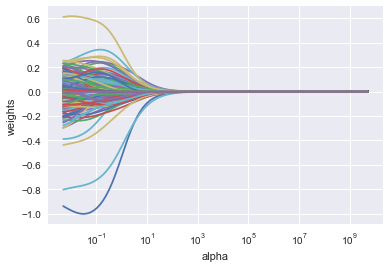

In [184]:
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')

In [185]:
#split data for training
train_x, test_x, train_y, test_y = cross_validation.train_test_split(x_train, y_train, test_size=0.2, random_state=1)
print train_x.shape
print test_x.shape

(24316, 328)
(6080, 328)


In [118]:
ridge2 = Ridge(alpha=4, normalize=True)
ridge2.fit(train_x, train_y)
# Fit a ridge regression on the training data
pred2 = ridge2.predict(test_x)
# Use this model to predict the test data
print(pd.Series(ridge2.coef_, index=x_train.columns))
# Print coefficients
print(mean_squared_error(test_y, pred2))
# Calculate the test MSE

full_sq                                  9.919165e-02
life_sq                                  1.295120e-03
floor                                    1.845073e-03
max_floor                                1.869430e-03
material                                 1.229941e-03
build_year                               3.411431e-09
num_room                                 2.945012e-02
kitch_sq                                 5.650685e-03
state                                    4.754969e-03
sub_area                                -9.736844e-05
area_m                                  -1.994952e-03
indust_part                             -6.892880e-02
preschool_quota                         -9.730115e-07
children_school                          1.814653e-03
school_quota                             1.494233e-07
school_education_centers_raion           1.668060e-03
school_education_centers_top_20_raion   -1.280945e-03
hospital_beds_raion                      4.232493e-06
healthcare_centers_raion    

In [104]:
ridge3 = Ridge(alpha=10**10, normalize=True)
ridge3.fit(train_x, train_y)
# Fit a ridge regression on the training data
pred3 = ridge3.predict(test_x)
# Use this model to predict the test data
print(pd.Series(ridge3.coef_, index=x_train.columns))
# Print coefficients
print(mean_squared_error(test_y, pred3))
# Calculate the test MSE

full_sq                                  1.356908e-12
life_sq                                  1.291450e-12
floor                                    1.439579e-12
max_floor                                1.258937e-12
material                                 2.313466e-12
build_year                               2.002752e-18
num_room                                 3.083828e-11
kitch_sq                                 5.030909e-12
state                                    6.896931e-12
sub_area                                -1.126994e-13
area_m                                  -4.598328e-19
indust_part                             -3.482245e-11
preschool_quota                         -8.615858e-16
children_school                          1.937438e-15
school_quota                             2.677025e-16
school_education_centers_raion           3.029825e-12
school_education_centers_top_20_raion    1.369469e-11
hospital_beds_raion                      6.915106e-15
healthcare_centers_raion    

In [186]:
ridgecv = RidgeCV(alphas=alphas, scoring='neg_mean_squared_error', normalize=True)
ridgecv.fit(train_x, train_y)
alpha = ridgecv.alpha_
print("Best alpha :", alpha)

('Best alpha :', 0.0050000000000000001)


In [156]:
ridgecv = RidgeCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, alpha * .85, 
                          alpha * .9, alpha * .95, alpha, alpha * 1.05, alpha * 1.1, alpha * 1.15,
                          alpha * 1.25, alpha * 1.3, alpha * 1.35, alpha * 1.4], 
                cv = 10)
ridgecv.fit(train_x, train_y)
alpha = ridgecv.alpha_
print("Best alpha :", alpha)

('Best alpha :', 0.0094500000000000001)


In [187]:
ridge4 = Ridge(alpha=ridgecv.alpha_, normalize=True)
ridge4.fit(train_x, train_y)
mean_squared_error(test_y, ridge4.predict(test_x))

0.207416142986066

In [188]:
print("Ridge RMSE on Training set :", rmse_cv_train(ridge4).mean())
print("Ridge RMSE on Test set :", rmse_cv_test(ridge4).mean())
y_train_rdg = ridge4.predict(train_x)
y_test_rdg = ridge4.predict(test_x)

('Ridge RMSE on Training set :', 0.46296076958827986)
('Ridge RMSE on Test set :', 0.46404653575211902)


In [159]:
cv_score_vl = cross_validation.cross_val_score(ridge4, test_x, test_y)
print cv_score_vl

[ 0.353053    0.39658272  0.37100857]


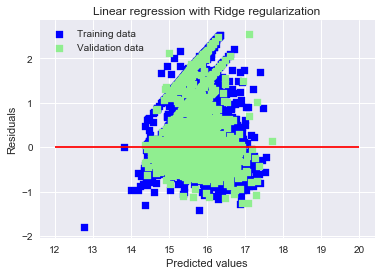

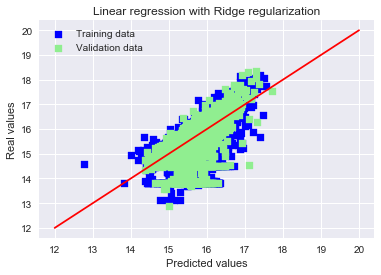

Ridge picked 327 features and eliminated the other 1 features


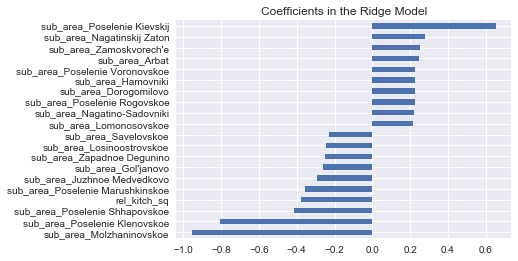

In [160]:
# Plot residuals
plt.scatter(y_train_rdg, y_train_rdg - train_y, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_rdg, y_test_rdg - test_y, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Ridge regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 12, xmax = 20, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train_rdg, train_y, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_rdg, test_y, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Ridge regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([12, 20], [12, 20], c = "red")
plt.show()

# Plot important coefficients
coefs = pd.Series(ridge4.coef_, index = train_x.columns)
print("Ridge picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Ridge Model")
plt.show()

### Lasso

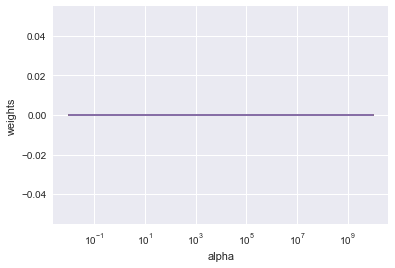

In [124]:
lasso = Lasso(max_iter=10000, normalize=True)
coefs = []
for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(scale(train_x), train_y)
    coefs.append(lasso.coef_)
ax = plt.gca()
ax.plot(alphas*2, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')

In [191]:
lassocv = LassoCV(alphas=None, cv=10, max_iter=100000, normalize=True)
lassocv.fit(train_x, train_y)
lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(train_x, train_y)
mean_squared_error(test_y, lasso.predict(test_x))

0.20692266599086062

In [194]:
print("Lasso RMSE on Training set :", rmse_cv_train(lasso).mean())
print("Lasso RMSE on Test set :", rmse_cv_test(lasso).mean())
y_train_lasso = lasso.predict(train_x)
y_test_lasso = lasso.predict(test_x)

('Lasso RMSE on Training set :', 0.46227881281924821)
('Lasso RMSE on Test set :', 0.46339458785799648)


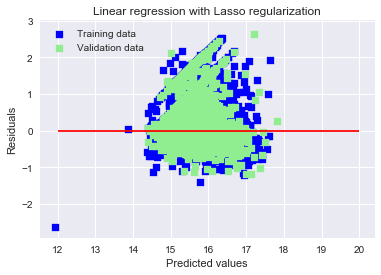

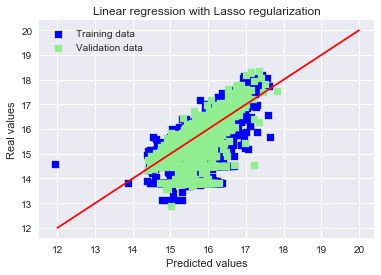

Lasso picked 249 features and eliminated the other 79 features


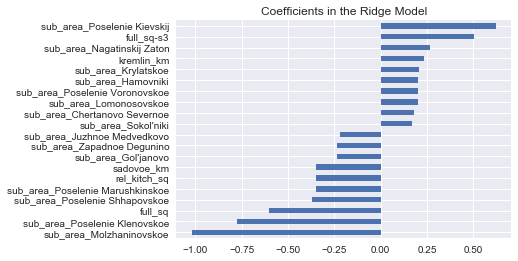

In [195]:
# Plot residuals
plt.scatter(y_train_lasso, y_train_lasso - train_y, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_lasso, y_test_lasso - test_y, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Lasso regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 12, xmax = 20, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train_lasso, train_y, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_lasso, test_y, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Lasso regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([12, 20], [12, 20], c = "red")
plt.show()

# Plot important coefficients
coefs = pd.Series(lasso.coef_, index = train_x.columns)
print("Lasso picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Ridge Model")
plt.show()

In [128]:
cv_score_lasso = cross_validation.cross_val_score(lasso, test_x, test_y)
print cv_score_lasso

[ 0.3502938   0.39885621  0.36832382]


### submission for linear

In [196]:
df_test = pd.read_csv("./data/input/test.csv", usecols =['id'])
y_predict = lasso.predict(x_test)
p_y =np.exp(y_predict)-1
id_test = df_test.id
lasso_output = pd.DataFrame({'id': id_test, 'price_doc': p_y})
lasso_output.head()

,id,price_doc
0,30474,5.215930e+06
1,30475,8.781101e+06
2,30476,5.256157e+06
3,30477,7.246039e+06
4,30478,5.471909e+06


In [197]:
lasso_output.to_csv('./data/output/lasso_dummy.csv', index=False)

In [189]:
df_test = pd.read_csv("./data/input/test.csv", usecols =['id'])
y_predict = ridge4.predict(x_test)
p_y =np.exp(y_predict)-1
id_test = df_test.id
ridge_output = pd.DataFrame({'id': id_test, 'price_doc': p_y})
ridge_output.head()

,id,price_doc
0,30474,5.223083e+06
1,30475,8.763339e+06
2,30476,5.286910e+06
3,30477,7.437631e+06
4,30478,5.484758e+06


In [192]:
ridge_output.to_csv('./data/output/ridge_dummy.csv', index=False)

### Random forest and GBM

In [ ]:
https://elitedatascience.com/python-machine-learning-tutorial-scikit-learn
    
    http://aplunket.com/random-forest-regressor/

In [47]:
# numeric data scaling 
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
# exclude CHAS as this is a categorical variable (by the river or not)
all_num_scaled = pd.DataFrame(sc.fit_transform(all_num), columns=all_num.columns.values)
all_num_scaled.shape

(38058, 161)

In [54]:
## Join categorical and numerical features
x_all = pd.concat([all_num_scaled, all_cat], axis = 1)
print("New number of features : " + str(x_all.shape[1]))

dtype_df = x_all.dtypes.reset_index()
dtype_df.columns = ["Count", "Column Type"]
dtype_df.groupby("Column Type").aggregate('count').reset_index()

New number of features : 328


,Column Type,Count
0,uint8,167
1,float64,161


In [55]:
#split to train and test
x_train = x_all[:num_train]
x_test = x_all[num_train:]

In [56]:
#split data for training
train_x, test_x, train_y, test_y = cross_validation.train_test_split(x_train, y_train, test_size=0.2, random_state=1)
print train_x.shape
print test_x.shape

(24316, 328)
(6080, 328)


In [84]:
#Hyperparameter selection
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

param_grid = {"n_estimators": [200, 500],
              "max_depth": [3, None],
              "max_features": [1, 3, 5, 10],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 3, 10],
    "bootstrap": [True, False]}

model = RandomForestRegressor(random_state=0)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
grid.fit(train_x, train_y)

print(grid.best_score_)
print(grid.best_params_)

0.420101724265
{'bootstrap': False, 'min_samples_leaf': 3, 'n_estimators': 500, 'min_samples_split': 10, 'max_features': 10, 'max_depth': None}


### Ramdon Forest Regression

In [88]:
from sklearn.ensemble import RandomForestRegressor
rf_est = RandomForestRegressor(random_state=0, n_estimators=500, max_depth=None, max_features=10, 
                                  min_samples_leaf=3, min_samples_split=10, bootstrap=False)
rf_est.fit(train_x, train_y)

RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=None,
           max_features=10, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=3, min_samples_split=10,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [89]:
rf_est.score(test_x, test_y)

0.43182590234177909

In [90]:
print("RF RMSE on Training set :", rmse_cv_train(rf_est).mean())
print("RM RMSE on Test set :", rmse_cv_test(rf_est).mean())
y_train_rf = rf_est.predict(train_x)
y_test_rf = rf_est.predict(test_x)

('RF RMSE on Training set :', 0.45528658656531962)
('RM RMSE on Test set :', 0.45947439765917275)


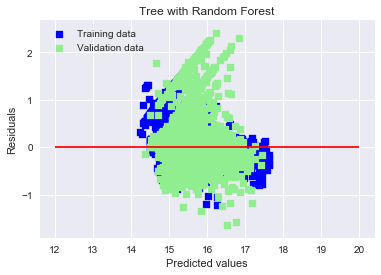

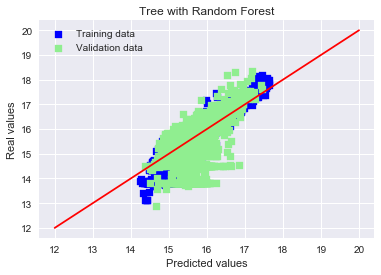

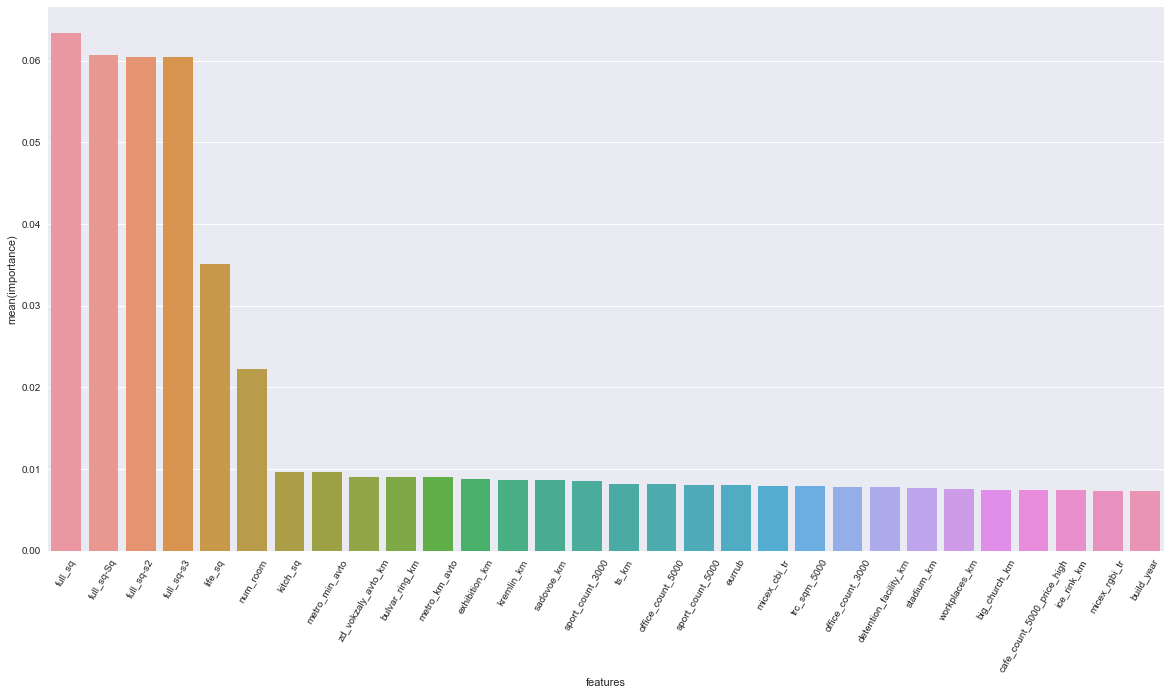

In [91]:
# Plot residuals
plt.scatter(y_train_rf, y_train_rf - train_y, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_rf, y_test_rf - test_y, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Tree with Random Forest")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 12, xmax = 20, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train_rf, train_y, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_rf, test_y, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Tree with Random Forest")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([12, 20], [12, 20], c = "red")
plt.show()

# Plot important feature
features = pd.DataFrame()
features['features'] = x_train.columns
features['importance'] = rf_est.feature_importances_
features.sort_values(by=['importance'],ascending=False,inplace=True)
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
plt.xticks(rotation=60)
sns.barplot(data=features.head(30),x="features",y="importance",ax=ax,orient="v")

In [92]:
cv_score_rf = cross_validation.cross_val_score(rf_est, test_x, test_y)
print cv_score_rf

[ 0.37230433  0.41321464  0.39582798]


In [93]:
df_test = pd.read_csv("./data/input/test.csv", usecols =['id'])

y_predict = rf_est.predict(x_test)
p_y =np.exp(y_predict)-1
id_test = df_test.id
rf_output = pd.DataFrame({'id': id_test, 'price_doc': p_y})
rf_output.head()

,id,price_doc
0,30474,5.216547e+06
1,30475,7.950118e+06
2,30476,5.230087e+06
3,30477,6.178606e+06
4,30478,5.105743e+06


In [94]:
rf_output.to_csv('./data/output/RF_dummy.csv', index=False)

### GBM

In [59]:
from math import (sqrt,exp,expm1)
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.grid_search import GridSearchCV,  RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_squared_error
from sklearn import cross_validation, metrics 
#Additional scklearn functions
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
from scipy import sparse
from sklearn.datasets import make_classification, make_blobs, load_boston, fetch_california_housing
from sklearn.decomposition import PCA
from sklearn.cross_validation import ShuffleSplit, train_test_split
from sklearn import metrics
from sklearn.learning_curve import learning_curve
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.grid_search import GridSearchCV
from pprint import pprint
import pandas as pd
from pandas.tools.plotting import scatter_matrix
import urllib
import requests
import zipfile
import StringIO
import seaborn

/Users/whalejasmine/anaconda/envs/python2/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/Users/whalejasmine/anaconda/envs/python2/lib/python2.7/site-packages/sklearn/learning_curve.py:23: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


In [60]:
gbrt= GradientBoostingRegressor(n_estimators=100)
gbrt.fit(train_x,train_y)
y_pred = gbrt.predict(test_x)

In [61]:
print "Feature Importance"
print gbrt.feature_importances_
print
print "R-squared for Train: %.2f" %gbrt.score(train_x,train_y)
print "R-squared for Test: %.2f" %gbrt.score(test_x,test_y)

Feature Importance
[  1.76165902e-03   3.79489271e-04   6.62662673e-03   5.26579775e-03
   3.92370161e-03   0.00000000e+00   7.73571812e-03   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   6.05431669e-03
   1.14369419e-03   2.70996312e-03   6.37174193e-04   3.78304242e-03
   0.00000000e+00   1.30890363e-03   1.48485108e-03   1.82883469e-03
   1.84438610e-03   3.50766270e-03   0.00000000e+00   3.23429196e-06
   1.74544635e-02   4.85134746e-03   5.08235409e-03   0.00000000e+00
   4.21047300e-03   6.44050887e-03   5.47448297e-03   2.61727831e-03
   0.00000000e+00   0.00000000e+00   2.05463501e-02   4.12842755e-03
   0.00000000e+00   1.32578094e-03   0.00000000e+00   0.00000000e+00
   4.66452171e-03   1.05863279e-02   2.11205991e-03   1.00419039e-03
   8.18928487e-04   0.00000000e+00   4.07332280e-03   8.67539175e-03
   5.92271728e-03   6.53631617e-03   2.42687578e-02   4.49083271e-02
   0.00000000e+00   2.24674344e-03   1.46944480e-02   0.00000000e+00
   6.79502616e-

In [62]:
def GradientBooster(param_grid, n_jobs): 
    estimator = GradientBoostingRegressor() 
    #for each iteration. There are other methods like the KFold split. 
    cv = ShuffleSplit(train_x.shape[0], n_iter=10, test_size=0.2) 
    classifier = GridSearchCV(estimator=estimator, cv=cv, param_grid=param_grid, n_jobs=n_jobs) 
    classifier.fit(train_x, train_y) 
    #Let's look at the best estimator that was found by GridSearchCV 
    print "Best Estimator learned through GridSearch"
    print classifier.best_estimator_ 
    return cv, classifier.best_estimator_

In [63]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import cross_validation
from sklearn.naive_bayes import GaussianNB
from sklearn.datasets import load_digits
from sklearn.learning_curve import learning_curve


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [64]:
param_grid={'n_estimators':[300], 
            'learning_rate': [0.02],# 0.05, 0.02, 0.01],
            'max_depth':[6],#4,6], 
            'min_samples_leaf':[5],#,5,9,17], 
            'max_features':[0.5],#,0.3]#,0.1]
           }
n_jobs=4

#Let's fit GBRT to the digits training dataset by calling the function we just created.
cv,best_est=GradientBooster(param_grid, n_jobs)

Best Estimator learned through GridSearch
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.02, loss='ls', max_depth=6, max_features=0.5,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=5, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=300,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)


In [65]:
best_est.fit(train_x, train_y)

print "Best Estimator Parameters"
print"---------------------------"
print "n_estimators: %d" %best_est.n_estimators
print "max_depth: %d" %best_est.max_depth
print "Learning Rate: %.1f" %best_est.learning_rate
print "min_samples_leaf: %d" %best_est.min_samples_leaf
print "max_features: %.1f" %best_est.max_features

print
print "Train R-squared: %.2f" %best_est.score(train_x,train_y)
print "Test R-squared: %.2f" %best_est.score(test_x,test_y)

Best Estimator Parameters
---------------------------
n_estimators: 300
max_depth: 6
Learning Rate: 0.0
min_samples_leaf: 5
max_features: 0.5

Train R-squared: 0.57
Test R-squared: 0.44


In [66]:
print("GBM RMSE on Training set :", rmse_cv_train(best_est).mean())
print("GBM RMSE on Test set :", rmse_cv_test(best_est).mean())
y_train_gbm = best_est.predict(train_x)
y_test_gbm = best_est.predict(test_x)

('GBM RMSE on Training set :', 0.4537744228142454)
('GBM RMSE on Test set :', 0.46215731990149383)


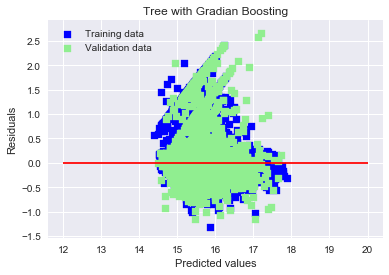

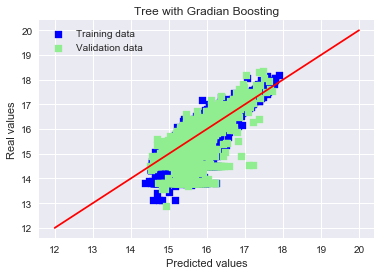

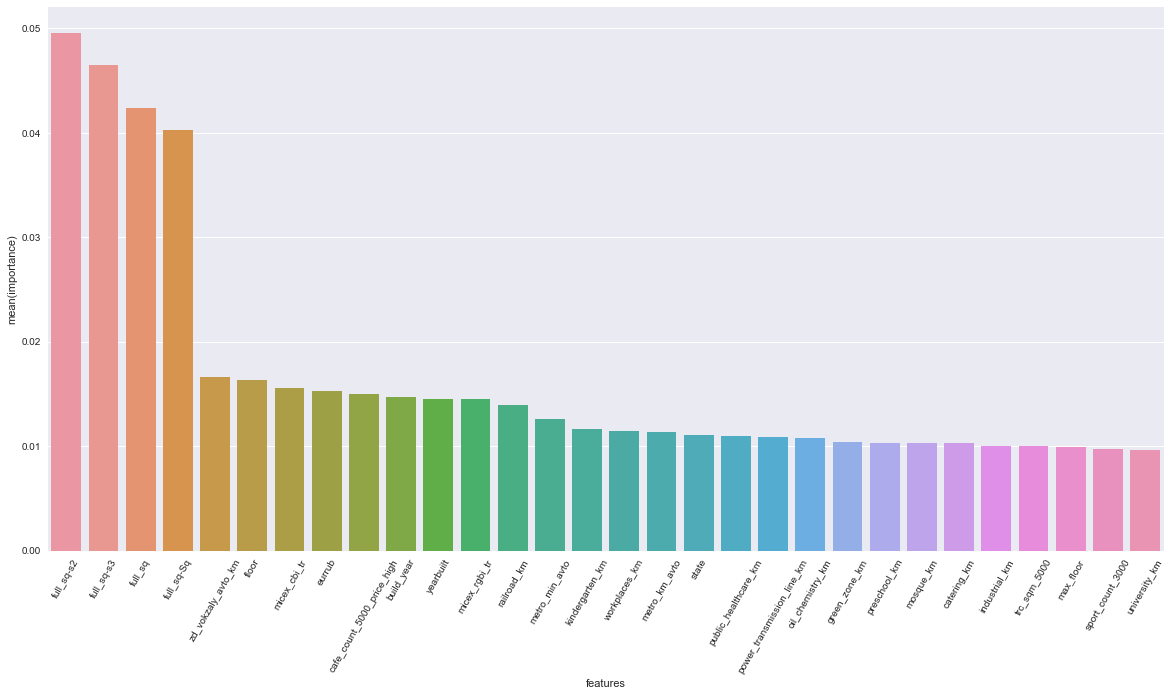

In [69]:
# Plot residuals
plt.scatter(y_train_gbm, y_train_gbm - train_y, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_gbm, y_test_gbm - test_y, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Tree with Gradian Boosting")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 12, xmax = 20, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train_gbm, train_y, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_gbm, test_y, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Tree with Gradian Boosting")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([12, 20], [12, 20], c = "red")
plt.show()

# Plot important feature
features = pd.DataFrame()
features['features'] = x_train.columns
features['importance'] = best_est.feature_importances_
features.sort_values(by=['importance'],ascending=False,inplace=True)
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
plt.xticks(rotation=60)
sns.barplot(data=features.head(30),x="features",y="importance",ax=ax,orient="v")

In [67]:
cv_score_gbm = cross_validation.cross_val_score(best_est, test_x, test_y)
print cv_score_gbm

[ 0.37112073  0.39628864  0.40012905]


In [68]:
df_test = pd.read_csv("./data/input/test.csv", usecols =['id'])

y_predict = best_est.predict(x_test)
p_y =np.exp(y_predict)-1
id_test = df_test.id
gbm_output = pd.DataFrame({'id': id_test, 'price_doc': p_y})
gbm_output.head()

,id,price_doc
0,30474,5.516031e+06
1,30475,8.258036e+06
2,30476,5.016373e+06
3,30477,6.103936e+06
4,30478,5.180794e+06


In [70]:
gbm_output.to_csv('./data/output/GBM_dummy.csv', index=False)

### XGB

In [243]:
import xgboost as xgb

In [240]:
dtrain = xgb.DMatrix(x_train, label = y_train)
dtest = xgb.DMatrix(x_test)

params = {"max_depth":2, "eta":0.1}
model = xgb.cv(params, dtrain,  num_boost_round=500, early_stopping_rounds=100)

TypeError: cv() got an unexpected keyword argument 'early_stopping_rounds'